# Example calculation of transport coefficients $L^{ij}$

This code uses output from molecular dynamics simulations (CMD/AIMD) to compute transport coefficients $L^{ij}$ in electrolyte solutions using the equation  

<center>$L^{ij} = \frac{1}{6k_{\mathrm{B}}TV}\lim_{t\to\infty}\frac{d}{dt} \big< \sum_{\alpha}[\boldsymbol{r}_i^{\alpha}(t)-\boldsymbol{r}_i^{\alpha}(0)]\cdot \sum_{\beta}[\boldsymbol{r}_j^{\beta}(t)-\boldsymbol{r}_j^{\beta}(0)]\big>$,</center>  

where $k_\mathrm{B}T$ is the thermal energy and $\boldsymbol{r}_i^{\alpha}$ is the position of particle $\alpha$ of type $i$ relative to the center of mass position of the system. We also compute the self and distinct components of the diagonal transport coefficients $L^{ii}$. The former is computed via

<center>$L^{ii}_{\mathrm{self}} = \frac{1}{6k_{\mathrm{B}}TV}\lim_{t\to\infty}\frac{d}{dt} \sum_{\alpha}\big< [\boldsymbol{r}_i^{\alpha}(t)-\boldsymbol{r}_i^{\alpha}(0)]^2\big>$,</center>

and the latter can be computed by $L^{ii}_{\mathrm{distinct}} = L^{ii} - L^{ii}_{\mathrm{self}}$. The self terms are related to the self-diffusion coefficients $D_i$ via $L^{ii}_{\mathrm{self}} = \frac{D_i c_i}{k_{\mathrm{B}}T}$. Throughout this example code we refer to the terms in angular brackets in the $L^{ij}$ and $L^{ii}_{\mathrm{self}}$ self equations as the "MSD", although it is only technically a mean-squared displacment in the latter case. 

### Preparation of input files

In [ ]:
In the working directory, we need: 

1. LAMMPS data file with initial particle positions and topology.

2. LAMMPS trajectory files (format .dcd) with particle positions over time (coordinates must be unwrapped).
        
Example portion of LAMMPS input script to generate trajectory files:  

    dump unwrapped all dcd 10000 traj_unwrapped.dcd  
    dump_modify unwrapped unwrap yes 

### Required packages

MDAnalysis, numpy, matplotlib, scipy

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
from scipy import stats
from MDAnalysis.tests.datafiles import PDB, GRO

## Define functions to compute transport coefficients

### Set up MDAnalysis Universe

In [37]:
def create_mda(topology_file, Coordinates_file):
    """
    Creates MDAnalysis universe with trajectory data.
    :param data_file: string, path to LAMMPS data file with atom coordinates and topology
    :param dcd_files: string or list[string], path(s) to LAMMPS dcd files with trajectory data
    :return run: MDAnalysis universe
    """
    run = mda.Universe(topology_file, Coordinates_file, topology_format="TPR", Coordinates_format='XTC')
    
    # print(run)
    # run = mda.Universe(data_file, dcd_files, format="LAMMPS")
    return run

In [38]:
def define_atom_types(run,anion_type="name N1",cation_type="id 79650:80250"): 
    """ 
    Sorts atoms in the MDAnalysis universe based on type (cation and anion).
    Selections must be a single atom or atom group (rather than a molecule center of mass).
    :param run: MDAnalysis universe
    :param anion_type: string, type number corresponding to anions in the LAMMPS input files
    :param cation_type: string, type number corresponding to cations in the LAMMPS input files
    :return cations, anions: MDAnalysis AtomGroups corresponding to cations and anions
    """
    anions = run.select_atoms(anion_type)
    cations = run.select_atoms(cation_type)
    return cations, anions

### Functions for ion correlation analysis

Functions for computing "MSDs"

In [39]:
# Algorithms in this section are adapted from DOI: 10.1051/sfn/201112010 and
# https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft

def autocorrFFT(x):
    """
    Calculates the autocorrelation function using the fast Fourier transform.
    
    :param x: array[float], function on which to compute autocorrelation function
    :return: acf: array[float], autocorrelation function
    """
    N=len(x)
    F = np.fft.fft(x, n=2*N)  
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   
    n=N*np.ones(N)-np.arange(0,N) 
    acf = res/n
    return acf

def msd_fft(r):
    """
    Computes mean square displacement using the fast Fourier transform.
    
    :param r: array[float], atom positions over time
    :return: msd: array[float], mean-squared displacement over time
    """
    N=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    msd = S1-2*S2
    return msd

def cross_corr(x, y):
    """
    Calculates cross-correlation function of x and y using the 
    fast Fourier transform.
    :param x: array[float], data set 1
    :param y: array[float], data set 2
    :return: cf: array[float], cross-correlation function
    """
    N=len(x)
    F1 = np.fft.fft(x, n=2**(N*2 - 1).bit_length())
    F2 = np.fft.fft(y, n=2**(N*2 - 1).bit_length())
    PSD = F1 * F2.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   
    n=N*np.ones(N)-np.arange(0,N)
    cf = res/n
    return cf

def msd_fft_cross(r, k):
    """
    Calculates "MSD" (cross-correlations) using the fast Fourier transform.
    :param r: array[float], positions of atom type 1 over time
    :param k: array[float], positions of atom type 2 over time
    :return: msd: array[float], "MSD" over time
    """
    N=len(r)
    D=np.multiply(r,k).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([cross_corr(r[:, i], k[:,i]) for i in range(r.shape[1])])
    S3=sum([cross_corr(k[:, i], r[:,i]) for i in range(k.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    msd = S1-S2-S3
    return msd

Functions for setting up trajectory data

In [40]:
def create_position_arrays(u, anions, cations, times):
    """
    Creates an array containing the positions of all cations and anions over time.
    :param u: MDAnalysis universe
    :param anions: MDAnalysis AtomGroup containing all anions (assumes anions are single atoms)
    :param cations: MDAnalysis AtomGroup containing all cations (assumes cations are single atoms)
    :param times: array[float], times at which position data was collected in the simulation
    :return anion_positions, cation_positions: array[float,float,float], array with all
    cation/anion positions. Indices correspond to time, ion index, and spatial dimension
    (x,y,z), respectively
    """
    time = 0
    anion_positions = np.zeros((len(times), len(anions), 3))
    cation_positions = np.zeros((len(times), len(cations), 3))
    for ts in u.trajectory[int(run_start/dt_collection):]:
        anion_positions[time, :, :] = anions.positions - u.atoms.center_of_mass(wrap=True)
        cation_positions[time, :, :] = cations.positions - u.atoms.center_of_mass(wrap=True)
        time += 1
    return anion_positions, cation_positions

def calc_Lii_self(atom_positions, times):
    """ 
    Calculates the "MSD" for the self component for a diagonal transport coefficient (L^{ii}).
    :param atom_positions: array[float,float,float], position of each atom over time.
    Indices correspond to time, ion index, and spatial dimension (x,y,z), respectively.
    :param times: array[float], times at which position data was collected in the simulation
    :return msd: array[float], "MSD" corresponding to the L^{ii}_{self} transport 
    coefficient at each time
    """
    Lii_self = np.zeros(len(times))
    n_atoms = np.shape(atom_positions)[1]
    for atom_num in (range(n_atoms)):
        r = atom_positions[:,atom_num, :]
        msd_temp = msd_fft(np.array(r))
        Lii_self += msd_temp
    msd = np.array(Lii_self)
    return msd

def calc_Lii(atom_positions, times):
    """ 
    Calculates the "MSD" for the diagonal transport coefficient L^{ii}. 
    :param atom_positions: array[float,float,float], position of each atom over time.
    Indices correspond to time, ion index, and spatial dimension (x,y,z), respectively.
    :param times: array[float], times at which position data was collected in the simulation
    :return msd: array[float], "MSD" corresponding to the L^{ii} transport 
    coefficient at each time
    """
    r_sum = np.sum(atom_positions, axis = 1)
    msd = msd_fft(r_sum)
    return np.array(msd)

def calc_Lij(cation_positions, anion_positions, times):
    """
    Calculates the "MSD" for the off-diagonal transport coefficient L^{ij}, i \neq j.
    :param cation_positions, anion_positions: array[float,float,float], position of each 
    atom (anion or cation, respectively) over time. Indices correspond to time, ion index,
    and spatial dimension (x,y,z), respectively.
    :param times: array[float], times at which position data was collected in the simulation
    :return msd: array[float], "MSD" corresponding to the L^{ij} transport coefficient at 
    each time.
    """
    r_cat = np.sum(cation_positions, axis = 1)
    r_an = np.sum(anion_positions, axis = 1)
    print(r_cat.shape)
    print(r_cat)
    print(r_an.shape)
    print(r_an)
    msd = msd_fft_cross(np.array(r_cat),np.array(r_an))
    return np.array(msd)

Functions for computing all transport coefficients

In [41]:
def compute_all_Lij(cation_positions, anion_positions, times, volume):
    """
    Computes the "MSDs" for all transport coefficients.
    :param cation_positions, anion_positions: array[float,float,float], position of each 
    atom (anion or cation, respectively) over time. Indices correspond to time, ion index,
    and spatial dimension (x,y,z), respectively.
    :param times: array[float], times at which position data was collected in the simulation
    :param volume: float, volume of simulation box
    :return msds_all: list[array[float]], the "MSDs" corresponding to each transport coefficient,
    L^{++}, L^{++}_{self}, L^{--}, L^{--}_{self}, L^{+-}
    """
    msd_self_cation = calc_Lii_self(cation_positions, times)/6.0/kbT/volume
    msd_self_anion =  calc_Lii_self(anion_positions, times)/6.0/kbT/volume
    msd_cation = calc_Lii(cation_positions, times)/6.0/kbT/volume
    msd_anion = calc_Lii(anion_positions, times)/6.0/kbT/volume
    msd_distinct_catAn = calc_Lij(cation_positions, anion_positions, times)/6.0/kbT/volume
    msds_all = [msd_cation, msd_self_cation, msd_anion, msd_self_anion, msd_distinct_catAn]
    return msds_all

In [42]:
def fit_data(f, start, end, times):
    """
    Perform a linear regression.
    :param f: array[float], "MSD" data
    :param start: int, time index at which to start fitting
    :param end: int, time index at which to end fitting
    :param times: array[float], times at which position data was collected in the simulation
    :return lij: float, transport coefficient, i.e., slope of "MSD" in fitting region
    """
    slope, intercept, r_value, p_value, std_err = stats.linregress(times[start:end], f[start:end])
    lij = slope
    return lij

## Compute transport coefficients

Note that the simulations here used Lennard-Jones units, and thus the transport coefficients have units of $(\tau\sigma\varepsilon)^{-1}$. The code can be directly applied to simulations with real units as well by changing the thermal energy and timestep in the cells below.

Enter information for simulation parameters

In [43]:
kbT = 4.11e-21  # Joules; Room Temperature of 298 K: (1.38E-23 J/K) * 298 K = 4.11E−21 J
# kbT = 1  thermal energy in Lennard-Jones units

In [44]:
dt = 0.002 # simulation timestep (ps; tau, Lennard-Jones unit of time)
dt_collection = 5e4 # position data is collected every dt_collection steps 
run_start = int(0) # omit this many steps from beginning of run (equilibration time)
t_total = 1001*5e4 - run_start  # total steps, minus equilibration time
times = np.arange(0,t_total*dt, dt*dt_collection, dtype=int)

print(len(times))

1001


Create MDAnalysis universe from data files

In [45]:
topology_file = "md.tpr"  # LAMMPS data file contatining atom coordinates and topology
Coordinates_file = "md_nopbc.xtc" # trajectory files

run = create_mda(topology_file, Coordinates_file)
                       
print(run.dimensions)

volume = run.dimensions[0]**3.0

[107.24038 107.24038 107.24038  90.       90.       90.     ]


In [46]:
print(run.trajectory[780]) # [0].positions)
print(run.atoms.center_of_mass(wrap=True))
print(run.atoms.masses)

< Timestep 780 with unit cell dimensions [102.464005 102.464005 102.464005  90.        90.        90.      ] >
[51.23077299 51.00672191 51.64982069]
[16.         16.         12.01000023 ...  6.94000006  6.94000006
  6.94000006]


Create arrays for the positions of the cations and anions at each time

In [47]:
cations, anions = define_atom_types(run)
anion_positions, cation_positions = create_position_arrays(run, anions, cations, times)

# print(cation_positions)

In [48]:
print(len(anions))
print(len(cations))
# print(anions.charges)
# print(cations.charges)
# print(run_start/dt_collection)
# print(anion_positions)
print(anion_positions.shape)
# print(anion_positions[1])
# print(len(cation_positions[1]))
print(cation_positions.shape)
# print(cation_positions[1])

600
600
(1001, 600, 3)
(1001, 600, 3)


Compute the "MSDs" for each of the transport coefficients (the terms in the angular brackets above). Taking the slope of these "MSDs" in the linear regime will yield the transport coefficients.

Plot each of the "MSDs" to determine the linear regime and perform a linear regression to compute the slope, which gives each of the transport coefficients. Note that this data is for only one simulation, and the linear regime is chosen based on visual inspection; for more reliable values of the transport coefficients, it is necessary to perform several replicate simulations and more rigorously analyze the linearity of the "MSDs".

#### $L^{++}$

L^{++} =  7.850112246709342e+16


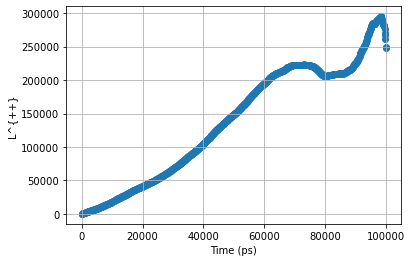

In [49]:
# choose linear fitting region (based on visual inspection of plot)
start = int(20000/dt_collection/dt)
end = int(60000/dt_collection/dt)

msd = msds_all[0]/len(cations)*6.0*kbT*volume

plt.scatter(times,msd)
# plt.plot(times[start:end], times[start:end]/1e-10, 'k--') # slope = 1
plt.xlabel('Time (ps)')
plt.ylabel('L^{++}')
plt.grid(which='major')

l_plusplus = fit_data(msd,start,end,times)/(6.0*kbT*volume)*len(cations)
print("L^{++} = ", l_plusplus)

#### $L^{++}_{\mathrm{self}}$

L^{++}_{self} =  3342683311458360.0


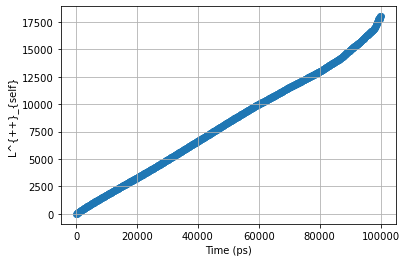

In [50]:
# choose linear fitting region (based on visual inspection of plot)
start = int(20000/dt_collection/dt)
end = int(60000/dt_collection/dt)

msd = msds_all[1]/len(cations)*6.0*kbT*volume

plt.scatter(times,msd)
# plt.plot(times[start:end], times[start:end]/1e-17, 'k--') # slope = 1
plt.xlabel('Time (ps)')
plt.ylabel('L^{++}_{self}')
plt.grid(which='major')

l_plusplus_self = fit_data(msd,start,end,times)/(6.0*kbT*volume)*len(cations)
print("L^{++}_{self} = ", l_plusplus_self)

#### $L^{--}$

L^{--} =  8.200328804276294e+16


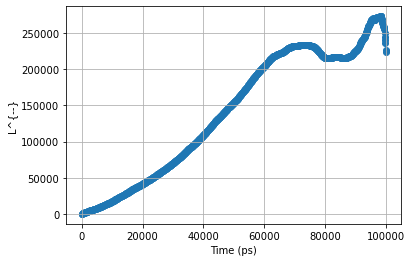

In [51]:
# choose linear fitting region (based on visual inspection of plot)
start = int(20000/dt_collection/dt)
end = int(60000/dt_collection/dt)

msd = msds_all[2]/len(cations)*6.0*kbT*volume
    
plt.scatter(times,msd)
# plt.plot(times[start:end], times[start:end]/1e-16, 'k--') # slope = 1
plt.xlabel('Time (ps)')
plt.ylabel('L^{--}')
plt.grid(which='major')

l_minusminus = fit_data(msd,start,end,times)/(6.0*kbT*volume)*len(cations)
print("L^{--} = ", l_minusminus)

#### $L^{--}_{\mathrm{self}}$

L^{--}_{self} =  3370082986198247.5


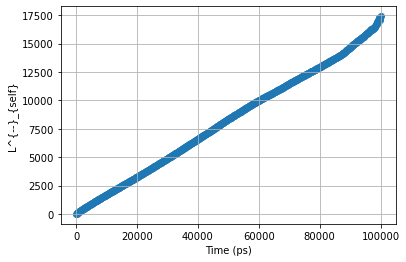

In [52]:
# choose linear fitting region (based on visual inspection of plot)
start = int(20000/dt_collection/dt)
end = int(60000/dt_collection/dt)

msd = msds_all[3]/len(cations)*6.0*kbT*volume

plt.scatter(times,msd)
# plt.plot(times[start:end], times[start:end]/1e-17, 'k--') # slope = 1
plt.xlabel('Time (ps)')
plt.ylabel('L^{--}_{self}')
plt.grid(which='major')

l_minusminus_self = fit_data(msd,start,end,times)/(6.0*kbT*volume)*len(cations)
print("L^{--}_{self} = ", l_minusminus_self)

#### $L^{+-}$

L^{+-} =  8.014743454113131e+16


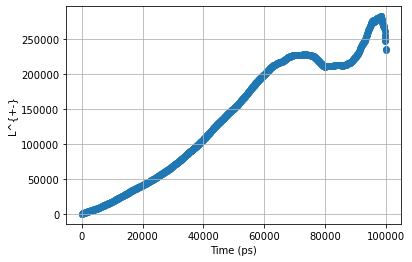

In [53]:
# choose linear fitting region (based on visual inspection of plot)
start = int(20000/dt_collection/dt)
end = int(60000/dt_collection/dt)

msd = msds_all[4]/len(cations)*6.0*kbT*volume
    
plt.scatter(times,msd)
# plt.plot(times[start:end], times[start:end]/1e-16, 'k--') # slope = 1
plt.xlabel('Time (ps)')
plt.ylabel('L^{+-}')
plt.grid(which='major')

l_plusminus = fit_data(msd,start,end,times)/(6.0*kbT*volume)*len(cations)
print("L^{+-} = ", l_plusminus)

#### $L^{++}_{\mathrm{distinct}} = L^{++} - L^{++}_{\mathrm{self}}$

In [54]:
l_plusplus_distinct = l_plusplus - l_plusplus_self
print("L^{++}_{distinct} = ", l_plusplus_distinct)

L^{++}_{distinct} =  7.515843915563507e+16


#### $L^{--}_{\mathrm{distinct}} = L^{--} - L^{--}_{\mathrm{self}}$

In [55]:
l_minusminus_distinct = l_minusminus - l_minusminus_self
print("L^{--}_{distinct} = ", l_minusminus_distinct)

L^{--}_{distinct} =  7.86332050565647e+16


## Compute ionic conductivity

In Lennard-Jones units, conductivity has units of $q^2/(\tau \sigma \varepsilon)$. 

In real units, one may typically have time in units of fs, charge in units of the elementary charge, thermal energy in units of Joules, and distance in units of Angstroms. If this is the case, the conductivity resulting from the following code could be converted to units of S/cm by multiplying by the following conversion factor: $(1.60217662 * 10^{-19} \;\mathrm{e/Coulomb})^2(10^{8}\;\mathring A\mathrm{/cm})(10^{15}\;\mathrm{ fs/s})$.

Conductivity = $L^{++} + L^{--} -2L^{+-}$ (assuming the cation and anion are both univalent).

In [56]:
conductivity = l_plusplus + l_minusminus - 2*l_plusminus
conductivity = conductivity*(1.60217662e-19)*(1.60217662e-19)*1e8*1e12  # (10^12 ps/s)
print("Ionic conductivity (real units: S/cm) = ",conductivity)
print("Ionic conductivity (real units: mS/cm) = ",conductivity*1000)

Ionic conductivity (real units: S/cm) =  0.0005378865419779432
Ionic conductivity (real units: mS/cm) =  0.5378865419779432
